In [41]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2

import pandas as pd
import os


from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, AutoETS
from statsforecast.utils import AirPassengersDF

from utilsforecast.losses import mse, mape
from utilsforecast.evaluation import evaluate

import matplotlib.pyplot as plt

os.environ['NIXTLA_ID_AS_COL'] = '1'


from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.models import NHITS, LSTM, PatchTST



env: PYTORCH_ENABLE_MPS_FALLBACK=1 #When running on Mac M1/M2


In [2]:
air_df = AirPassengersDF
# air_df = air_df.rename(columns={"unique_id" : "id"})

air_train_df = air_df.iloc[:-12]
air_test_df = air_df.iloc[-12:]

In [3]:
air_df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


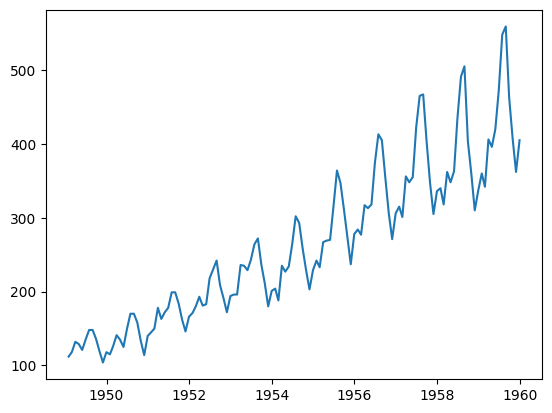

In [4]:
plt.plot(air_train_df['ds'],air_train_df['y']);

In [5]:
models_trend_seasonal = [
    MSTL(season_length=[12])
]

sf_trend_seasonal = StatsForecast(
    models=models_trend_seasonal, 
    freq='ME', #monthly frequency
)

sf_trend_seasonal.fit(air_train_df)

StatsForecast(models=[MSTL])

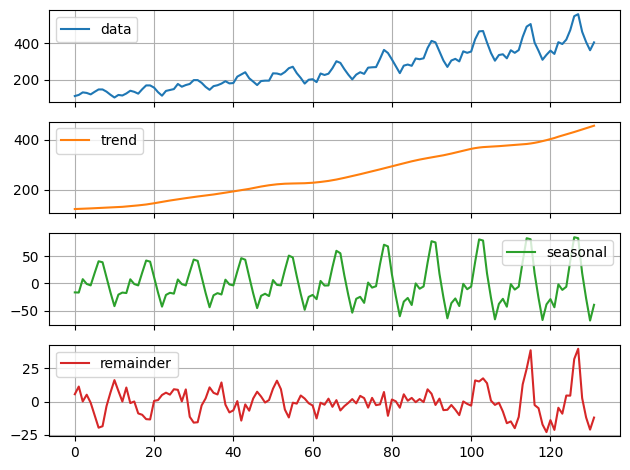

In [6]:
sf_trend_seasonal.fitted_[0, 0].model_.plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

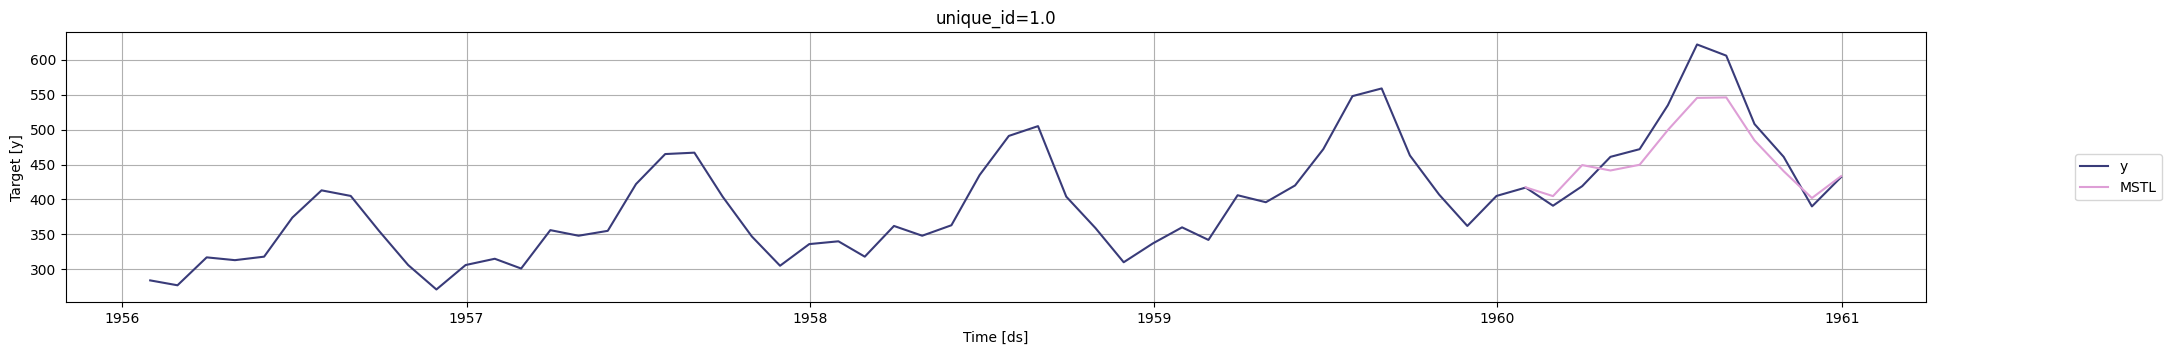

In [7]:
air_pred_df = sf_trend_seasonal.predict(h=12)
sf_trend_seasonal.plot(air_df, air_pred_df, max_insample_length=5*12)

In [8]:
sf_classical = StatsForecast(
    models=[
        AutoARIMA(season_length = 12),
        AutoETS(season_length = 12, damped=True),
        MSTL(season_length=12)        
        ],
    freq='ME',
)

sf_classical.fit(air_train_df)

StatsForecast(models=[AutoARIMA,AutoETS,MSTL])

In [9]:
air_pred_classical_df = sf_classical.predict(h=12)

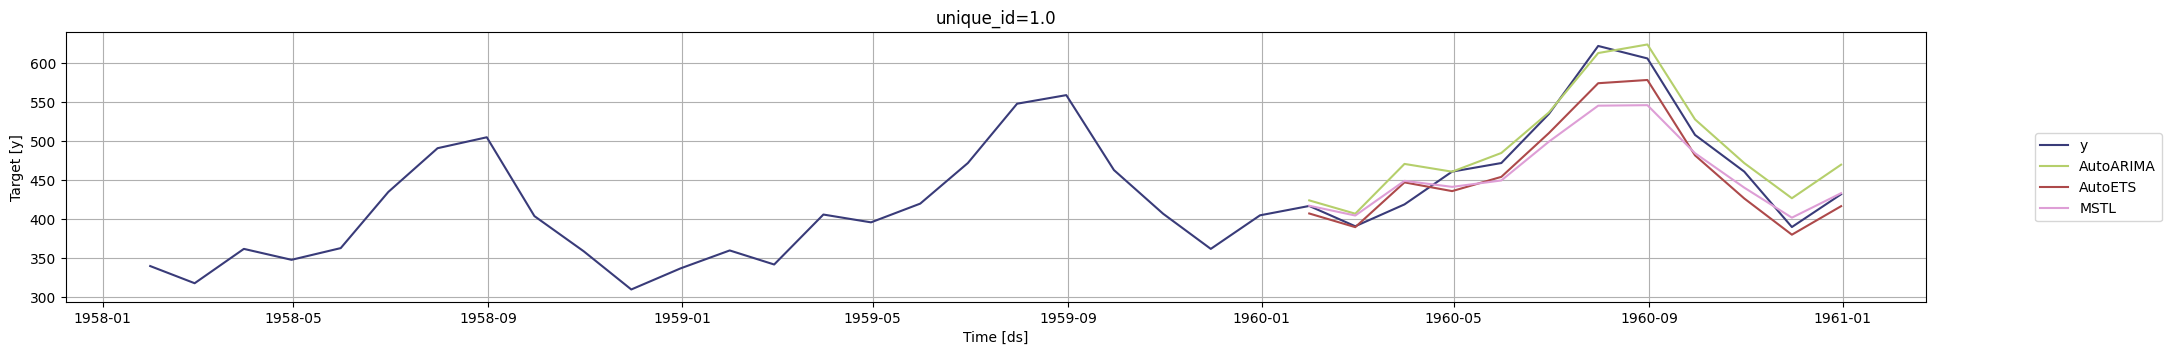

In [10]:
sf_classical.plot(air_df, air_pred_classical_df , max_insample_length=3*12)

### Evaluate Predictions ###

In [11]:
air_eval_classical_df = air_pred_classical_df.copy()
air_eval_classical_df['y'] = air_test_df['y'].values

mape(air_eval_classical_df,['AutoARIMA','AutoETS','MSTL'])


,unique_id,AutoARIMA,AutoETS,MSTL
0,1.0,0.041876,0.044994,0.050862


### Backtest ###

In [12]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [13]:
air_backtest_df = sf_classical.cross_validation(
    df=air_df,
    h=12,
    step_size=1,
    n_windows=12
)
evaluate_cross_validation(air_backtest_df.reset_index(), mape)

,index,AutoARIMA,AutoETS,MSTL,best_model
unique_id,,,,,
1.0,0.842413,0.043734,0.063208,0.0604,AutoARIMA


### Neural Network Models

In [46]:
horizon = 1

model_PatchTST = PatchTST(h=horizon,
                 input_size=104,
                 patch_len=24,
                 stride=24,
                 revin=False,
                 hidden_size=16,
                 n_heads=4,
                 scaler_type='robust',
                #  loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 #loss=MAE(),
                 learning_rate=1e-3,
                 max_steps=200,
                 val_check_steps=50,
                #  early_stop_patience_steps=2
                 )

Seed set to 1


In [50]:


sf_neural = NeuralForecast(models=[
    NHITS(h=horizon, input_size=24, max_steps=200),
    LSTM(h=horizon, encoder_hidden_size=128, decoder_hidden_size=128, max_steps=200),
    model_PatchTST
], freq='M')

Seed set to 1
Seed set to 1


In [51]:
air_backtest_neural_df = sf_neural.cross_validation(air_train_df, n_windows=12)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


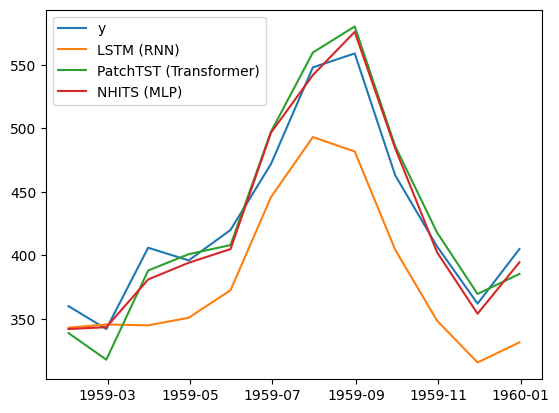

In [56]:
plt.plot(air_backtest_neural_df['ds'], air_backtest_neural_df['y'], label='y')
plt.plot(air_backtest_neural_df['ds'], air_backtest_neural_df['LSTM'], label='LSTM (RNN)')
plt.plot(air_backtest_neural_df['ds'], air_backtest_neural_df['PatchTST'], label='PatchTST (Transformer)')
plt.plot(air_backtest_neural_df['ds'], air_backtest_neural_df['NHITS'], label='NHITS (MLP)')
plt.legend()

In [57]:
mape(air_backtest_neural_df,['LSTM','PatchTST','NHITS'])

,unique_id,LSTM,PatchTST,NHITS
0,1.0,0.109056,0.03947,0.029583


### Interpretable Models ###